In [22]:
import pandas as pd
import os
from src.data import files_to_df

SOURCE_PATH_ORIG = "data/1_original/txt"
SOURCE_PATH_GEN = "data/2_generated/2step_transformation_dt4h_GPT4omini/en"

def create_pairs(path_orig, path_gen):

    df_gen = files_to_df(path_gen)
    df_gen["filenameid"] = df_gen["filenameid"].str.replace("_transformed_step1", "")

    df_orig = files_to_df(path_orig)
    df_pairs = df_orig.merge(df_gen, on="filenameid", suffixes=("_orig", "_gen"))
    # assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

    df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"}, inplace=True)
    return df_pairs

df_pairs = create_pairs(SOURCE_PATH_ORIG, SOURCE_PATH_GEN)

df_cc_ents = pd.read_csv("nbs/evaluation/automatic/cardioner_entities/NOIOB_EN_clinical_case_ents.tsv", sep="\t")
df_cc_ents["codes"] = df_cc_ents["codes"].apply(eval)
df_cc_ents["terms"] = df_cc_ents["terms"].apply(eval)
df_cc_ents["mention_id"] = df_cc_ents.index

df_ds_ents = pd.read_csv("nbs/evaluation/automatic/cardioner_entities/NOIOB_EN_discharge_summary_ents.tsv", sep="\t")
df_ds_ents["codes"] = df_ds_ents["codes"].apply(eval)
df_ds_ents["terms"] = df_ds_ents["terms"].apply(eval)
df_ds_ents["mention_id"] = df_ds_ents.index

In [23]:
print(df_cc_ents.duplicated(subset=["filenameid", "text"]).sum())
print(df_ds_ents.duplicated(subset=["filenameid", "text"]).sum())

df_cc_ents = df_cc_ents.drop_duplicates(subset=["filenameid", "text"])
df_ds_ents = df_ds_ents.drop_duplicates(subset=["filenameid", "text"])

print(df_cc_ents.duplicated(subset=["filenameid", "text"]).sum())
print(df_ds_ents.duplicated(subset=["filenameid", "text"]).sum())

39
25
0
0


In [24]:
ex1 = df_cc_ents.loc[df_cc_ents["filenameid"] == "33175723_1", ["filenameid", "label", "text", "terms", "mention_id"]]
ex2 = df_ds_ents.loc[df_ds_ents["filenameid"] == "33175723_1", ["filenameid", "label", "text", "terms", "mention_id"]]

In [25]:
ex1.shape, ex2.shape

((34, 5), (35, 5))

In [26]:
df_ex = ex1.merge(ex2, on=["filenameid"], how="outer", suffixes=("_cc", "_ds"))#[["filenameid", "codes_cc", "codes_ds"]].to_dict(orient="records")

In [27]:
df_ex["inter_size"] = df_ex.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
df_ex["positive"] = df_ex.apply(lambda x: 1 if x["inter_size"] > 0 else 0, axis=1)

In [28]:
df_ex.sort_values(by=["inter_size"], ascending=False)

,filenameid,label_cc,text_cc,terms_cc,mention_id_cc,label_ds,text_ds,terms_ds,mention_id_ds,inter_size,positive
289,33175723_1,DISEASE,periorbital hematoma,"[Periorbital hematoma, Periorbital haematoma, ...",8,DISEASE,periorbital hematoma,"[Periorbital hematoma, Periorbital haematoma, ...",9,10,1
540,33175723_1,PROCEDURE,chemotherapy,"[Chemotherapy, Chemotherapy care, CT - Chemoth...",12226,PROCEDURE,Chemotherapy,"[Chemotherapy, Chemotherapy care, CT - Chemoth...",12236,10,1
613,33175723_1,PROCEDURE,ECG,"[Electrocardiogram, Electrocardiography proced...",12228,PROCEDURE,ECG,"[Electrocardiogram, Electrocardiography proced...",12239,10,1
253,33175723_1,DISEASE,pseudoinfarction pattern in the precordial leads,"[Preinfarction syndrome, Preinfarction angina,...",7,DISEASE,pseudoinfarction pattern in the precordial leads,"[Preinfarction syndrome, Preinfarction angina,...",8,10,1
758,33175723_1,PROCEDURE,Bone marrow biopsy,"[Bone marrow biopsy, Non-surgical bone marrow ...",12232,PROCEDURE,bone marrow biopsy,"[Bone marrow biopsy, Non-surgical bone marrow ...",12244,10,1
...,...,...,...,...,...,...,...,...,...,...,...
1175,33175723_1,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23573,PROCEDURE,hematological investigations,"[Hematology procedure, Hematology test, Haemat...",12241,0,0
1154,33175723_1,SYMPTOM,decreased glomerular filtration rate,"[Glomerular filtration rate decreased, Glomeru...",23572,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23035,0,0
1155,33175723_1,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23573,DISEASE,Amyloid light-chain amyloidosis,"[Amyloid light-chain amyloidosis, Primary amyl...",0,0,0
1156,33175723_1,SYMPTOM,sinus rhythm,"[Sinus rhythm, SR - Sinus rhythm, Coronary sin...",23573,DISEASE,Cardiac amyloidosis,"[Cardiac amyloidosis, Senile cardiac amyloidos...",1,0,0


In [29]:
def get_notnull_intersection(group):
    return group[group["inter_size"] > 0].sort_values(by="inter_size", ascending=False)["text_ds"].tolist()

In [30]:
len(list(set(df_ex.groupby("text_cc").apply(get_notnull_intersection).sum())))

C:\Users\alber\AppData\Local\Temp\ipykernel_14096\4088920469.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  len(list(set(df_ex.groupby("text_cc").apply(get_notnull_intersection).sum())))


34

In [31]:
len(list(set(df_ex.groupby("text_ds").apply(get_notnull_intersection).sum())))

C:\Users\alber\AppData\Local\Temp\ipykernel_14096\642089737.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  len(list(set(df_ex.groupby("text_ds").apply(get_notnull_intersection).sum())))


34

In [32]:
df_total = df_cc_ents.merge(df_ds_ents, on=["filenameid"], how="outer", suffixes=("_cc", "_ds"))
df_total = df_total[df_total["label_cc"] == df_total["label_ds"]]

In [33]:
df_total["inter_size"] = df_total.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)

# df_total = df_total.sort_values(by=["filenameid", "mention_id_cc", "inter_size"], ascending=[True, True, False])

df_total[df_total["filenameid"] == "39101327"]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
1142677,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,severe malnutrition,"[29740003, 2492009, 58262005, 248325000, 44195...","[Severe malnutrition, Malnutrition, Malignant ...",7979,0
1142678,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,cardiogenic shock,"[89138009, 417343009, 328851000119107, 2794200...","[Cardiogenic shock, Vasogenic shock, Cardiogen...",7980,0
1142679,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,Whipple disease,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7981,10
1142680,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,heart failure with cardiomyopathy,"[101281000119107, 399020009, 703275009, 831050...",[Congestive heart failure due to cardiomyopath...,7982,0
1142681,DISEASE,Whipple disease,39101327,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",7871,DISEASE,cirrhosis,"[19943007, 19943007, 89580002, 74669004, 12371...","[Hepatic cirrhosis, Cirrhosis of liver, Idiopa...",7983,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1144152,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,enlarged left ventricular chamber,"[93053007, 373128001, 93051009, 373126002, 253...","[Congenital enlarged ventricular chamber, Mark...",30157,0
1144153,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,Whipple,"[41545003, 41545003, 41545003, 41545003, 23019...","[Whipple disease, Whipple's disease, Intestina...",30158,0
1144154,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,in,"[161056001, 2438005, 127569003, 315444002, 775...","[In care, Iniencephaly, In situ neoplasm, Born...",30159,0
1144155,SYMPTOM,nutritional,39101327,"[300893006, 2492009, 2492009, 29740003, 249200...","[Nutritional finding, Nutritional disease, Nut...",31224,SYMPTOM,: Negative,"[442225006, 278154007, 225462008, 165746003, 3...","[Negative measurement finding, Group AB neg, N...",30160,0


In [34]:
df_total.head()

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10
1,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,0
2,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,0
3,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,0
4,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,severely impaired ventricular function,"[397541004, 85232009, 84114007, 708024004, 925...","[Severe visual impairment, Left ventricular fa...",3799,0


In [35]:
df_inter_cc = df_total\
              .sort_values(by=["filenameid", "mention_id_cc", "inter_size"], ascending=[True, True, False])\
              .groupby(["filenameid", "mention_id_cc"]).head(1) # for each mention in cc one mention in ds (it can be the same for 2 different mentions in cc)
df_inter_ds = df_total\
                .sort_values(by=["filenameid", "mention_id_ds", "inter_size"], ascending=[True, True, False])\
                .groupby(["filenameid", "mention_id_ds"]).head(1) # for each mention in ds one mention in cc (it can be the same for 2 different mentions in ds)

print(df_inter_cc.shape)
print(df_inter_ds.shape)

(33160, 12)
(32122, 12)


In [36]:
# df_inter_total = df_total.groupby(["filenameid", "mention_id_cc", "mention_id_ds"]).head(1)

Text(0.5, 0.98, 'Distribution of intersection size')

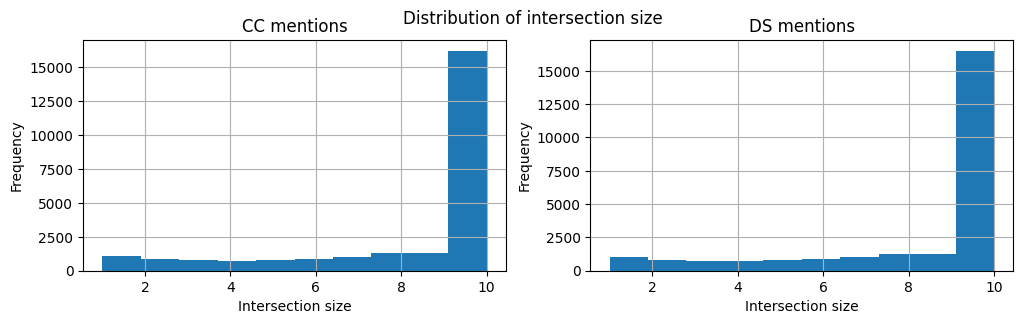

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

df_inter_cc[df_inter_cc["inter_size"] > 0].inter_size.hist(ax=ax[0], bins=10)
ax[0].set_title("CC mentions")
ax[0].set_xlabel("Intersection size")
ax[0].set_ylabel("Frequency")

df_inter_ds[df_inter_ds["inter_size"] > 0].inter_size.hist(ax=ax[1], bins=10)
ax[1].set_title("DS mentions")
ax[1].set_xlabel("Intersection size")
ax[1].set_ylabel("Frequency")
plt.suptitle("Distribution of intersection size")
# plt.savefig("img/automatic_metric/intersection_size.png", dpi=300, bbox_inches="tight")

In [38]:
df_n_mentions_cc = df_inter_cc.groupby("filenameid")["mention_id_cc"].nunique().reset_index()
df_n_mentions_ds = df_inter_ds.groupby("filenameid")["mention_id_ds"].nunique().reset_index()
df_n_mentions_cc.columns = ["filenameid", "n_mentions_cc"]
df_n_mentions_ds.columns = ["filenameid", "n_mentions_ds"]
df_n_mentions_cc

,filenameid,n_mentions_cc
0,25350173,29
1,25531204,39
2,25654384,55
3,25679083,35
4,25725033,22
...,...,...
995,38985686,22
996,39018148,32
997,39044225,27
998,39098903,24


In [39]:
df_n_mentions_ds

,filenameid,n_mentions_ds
0,25350173,26
1,25531204,36
2,25654384,51
3,25679083,37
4,25725033,28
...,...,...
995,38985686,24
996,39018148,33
997,39044225,25
998,39098903,32


In [40]:
print(df_inter_ds.mention_id_ds.nunique(), df_inter_cc.mention_id_cc.nunique())
print(df_inter_ds.shape, df_inter_cc.shape)

32122 33160
(32122, 12) (33160, 12)


In [41]:
df_inter_cc[df_inter_cc["inter_size"] == 2]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size
81,DISEASE,severely dilated left ventricle,25350173,"[253541009, 840305006, 253541009, 6210001, 621...","[Dilatation of left cardiac ventricle, Severe ...",3717,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,2
189,DISEASE,arrhythmia,25350173,"[698247007, 698247007, 17366009, 44103008, 717...","[Arrhythmia, Cardiac arrhythmia, Atrial arrhyt...",3721,DISEASE,arrhythmogenic scar tissue,"[880040003, 735686002, 698247007, 253528005, 7...",[Arrhythmogenic left ventricular cardiomyopath...,3802,2
404,PROCEDURE,Percutaneous coronary intervention,25350173,"[415070008, 415070008, 405741001, 414089002, 8...","[Percutaneous coronary intervention, PCI - Per...",16459,PROCEDURE,Percutaneous coronary intervention was success...,"[868246006, 868246006, 1258931005, 868245005, ...",[Percutaneous coronary intervention of anterio...,16239,2
1382,PROCEDURE,inflammatory markers,25531204,"[49352002, 75777003, 32813003, 285319004, 1061...","[Mediator of inflammation, Cytokine, Cytokine ...",14327,PROCEDURE,markers,"[277565005, 468052006, 262308003, 391485008, 7...","[Radiology marker, Bone marker, Skin marker, C...",14243,2
9623,DISEASE,at,25878230,"[68504005, 35919005, 432414001, 68504005, 6850...","[Ataxia telangiectasia, Autism, Atonic constip...",8991,DISEASE,mild anemia,"[271737000, 271737000, 271737000, 370218001, 2...","[Anemia, Absolute anemia, Anaemia, Mild asthma...",9120,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1133390,SYMPTOM,pulmonary ven,38904301,"[304522008, 77892009, 304523003, 77892009, 128...","[Pulmonary vein finding, Pulmonary venous thro...",30192,SYMPTOM,Pulmonary venous congestion,"[304523003, 67599009, 8804002, 8804002, 638410...","[Pulmonary venous congestion, Pulmonary conges...",29216,2
1136772,SYMPTOM,",",38923781,"[64572001, 64572001, 52988006, 64572001, 64572...","[Diseases, Disease, Lesion, Disorder, Disorder...",32614,SYMPTOM,distress,"[69328002, 224977004, 224977004, 271596009, 24...","[Distress, Feeling distress, Distressed, Menta...",31498,2
1137003,SYMPTOM,left ventricle with normal size,38923781,"[414072005, 373124004, 53461003, 53461003, 371...",[Echocardiogram shows normal left ventricular ...,32619,SYMPTOM,normal vital signs,"[72970002, 64826008, 118227000, 39968002, 5346...","[Normal vital signs, Normal blood volume, Vita...",31499,2
1141428,PROCEDURE,transthoracic echocardiography,39044225,"[433236007, 105376000, 105376000, 105376000, 7...","[Transthoracic echocardiography, Transesophage...",21805,PROCEDURE,Echocardiography,"[40701008, 40701008, 40701008, 40701008, 43323...","[Echocardiography, Echocardiogram, Echocardiog...",21258,2


(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)


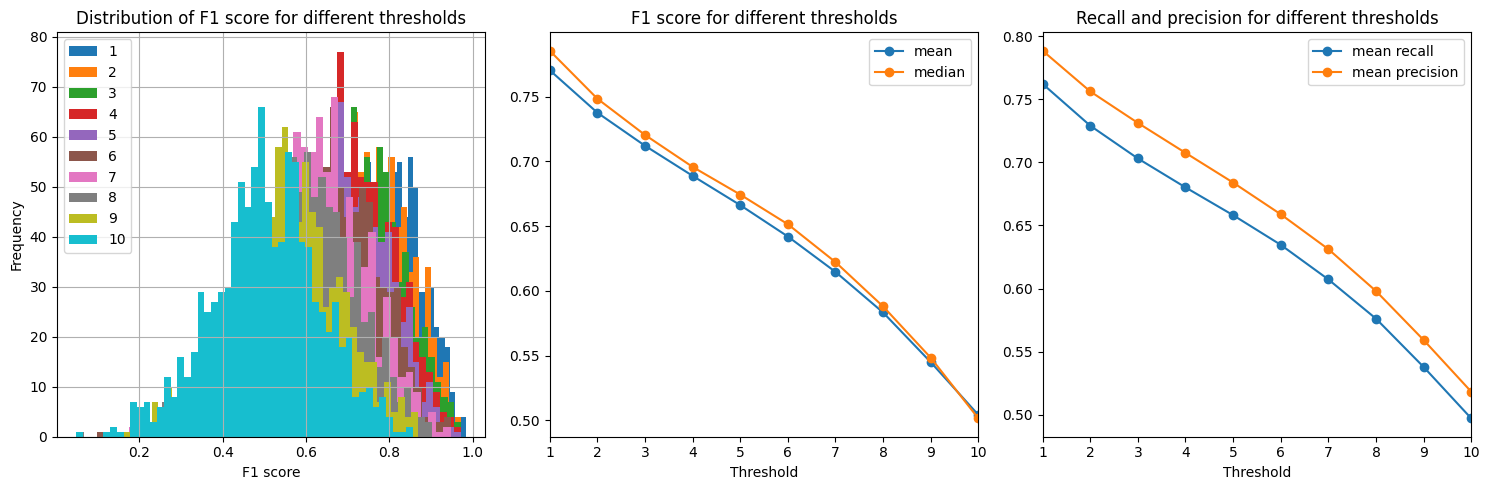

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ls_thres = list(range(1, 11))
ls_mean = []
ls_median = []
ls_mean_recall = []
ls_mean_precision = []
for threshold in ls_thres:
    df_aux_cc = df_inter_cc.copy()
    df_aux_cc["inter_size"] = df_aux_cc.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
    df_aux_cc["top_rank"] = df_aux_cc.apply(lambda x: min([x["terms_cc"].index(y) if y in x["terms_cc"] else 999 for y in x["terms_ds"]]), axis=1)

    df_aux_cc.loc[:, "tp"] = df_aux_cc.apply(lambda x: 1 if (x["inter_size"] >= threshold)&(x["label_cc"] == x["label_ds"]) else 0, axis=1)
    
    df_aux_ds = df_inter_ds.copy()
    df_aux_ds["inter_size"] = df_aux_ds.apply(lambda x: len(set(x["terms_cc"]).intersection(set(x["terms_ds"]))), axis=1)
    df_aux_ds["top_rank"] = df_aux_ds.apply(lambda x: min([x["terms_ds"].index(y) if y in x["terms_ds"] else 999 for y in x["terms_cc"]]), axis=1)
    df_aux_ds.loc[:, "tp"] = df_aux_ds.apply(lambda x: 1 if (x["inter_size"] >= threshold)&(x["label_cc"] == x["label_ds"]) else 0, axis=1)

    df_auto_score_cc = df_aux_cc.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_cc = df_auto_score_cc.merge(df_n_mentions_cc, on="filenameid", how="left")
    # df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
    df_auto_score_cc = df_auto_score_cc.fillna(0)
    
    df_auto_score_ds = df_aux_ds.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_ds = df_auto_score_ds.merge(df_n_mentions_ds, on="filenameid", how="left")
    # df_auto_score_ds = df_auto_score_ds.rename(columns={"tp": "tp_ds"})
    df_auto_score_ds = df_auto_score_ds.fillna(0)

    print(df_auto_score_cc.shape, df_auto_score_ds.shape)
    
    df_auto_score = df_auto_score_cc.merge(df_auto_score_ds, on="filenameid", how="left", suffixes=("_cc", "_ds"))
    df_auto_score["precision"] = df_auto_score["tp_ds"] / df_auto_score["n_mentions_ds"]
    df_auto_score["recall"] = df_auto_score["tp_cc"] / df_auto_score["n_mentions_cc"]
    df_auto_score["f1"] = 2 * df_auto_score["precision"] * df_auto_score["recall"] / (df_auto_score["precision"] + df_auto_score["recall"])

    df_auto_score["f1"].hist(bins=50, label=str(threshold), ax=ax[0])
    

    ax[0].set_title("Distribution of F1 score for different thresholds")
    ax[0].set_xlabel("F1 score")
    ax[0].set_ylabel("Frequency")
    ax[0].legend()
    
    ls_mean.append(df_auto_score["f1"].mean())
    ls_median.append(df_auto_score["f1"].median())
    
    ls_mean_recall.append(df_auto_score["recall"].mean())
    ls_mean_precision.append(df_auto_score["precision"].mean())
    
ax[1].plot(ls_thres, ls_mean, label="mean", marker="o")
ax[1].plot(ls_thres, ls_median, label="median", marker="o")
ax[1].set_title("F1 score for different thresholds")
ax[1].set_xlabel("Threshold")
ax[1].set_xlim(1, 10)
ax[1].legend()

ax[2].plot(ls_thres, ls_mean_recall, label="mean recall", marker="o")
ax[2].plot(ls_thres, ls_mean_precision, label="mean precision", marker="o")
ax[2].set_title("Recall and precision for different thresholds")
ax[2].set_xlabel("Threshold")
ax[2].set_xlim(1, 10)
ax[2].legend()

plt.tight_layout()
plt.savefig("img/automatic_metric/threshold_analysis.png", dpi=300, bbox_inches="tight")

Observed 8 as a good threshold

In [43]:
df_inter_cc["top_rank"] = df_inter_cc.apply(lambda x: min([x["terms_cc"].index(y) + 1 if y in x["terms_cc"] else 999 for y in x["terms_ds"]]), axis=1)
df_inter_ds["top_rank"] = df_inter_ds.apply(lambda x: min([x["terms_ds"].index(y) + 1 if y in x["terms_ds"] else 999 for y in x["terms_cc"]]), axis=1)

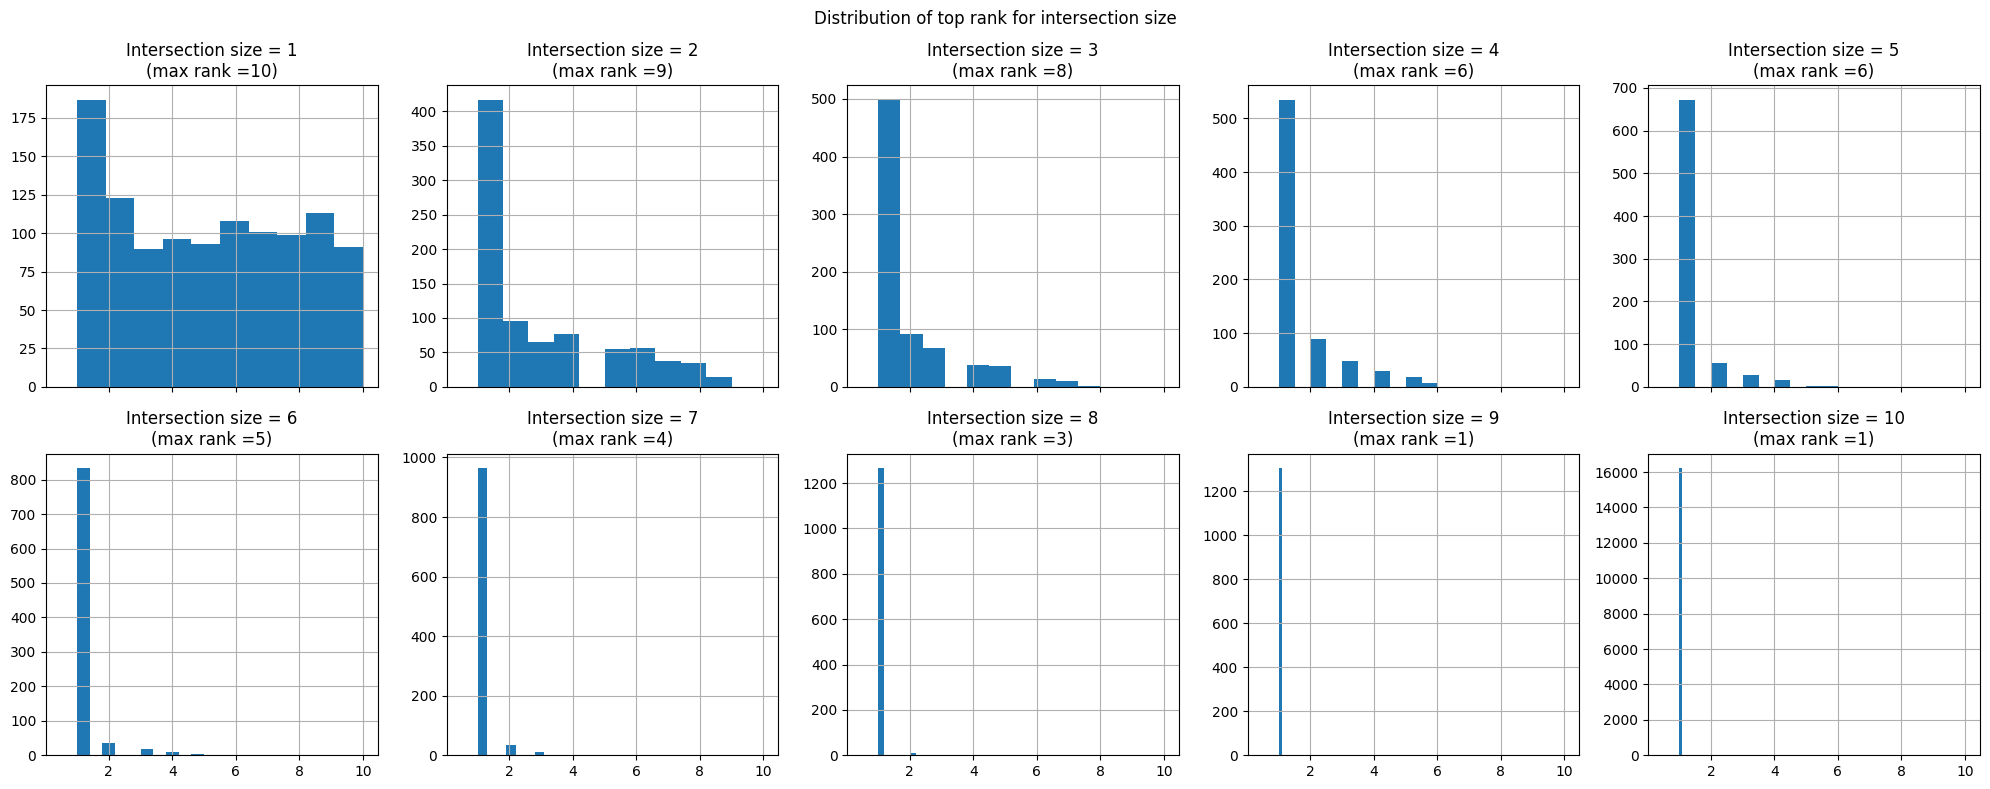

In [44]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex=True)
axx = ax.flatten()
for pos in range(1, 11):
    ranks = df_inter_cc[(df_inter_cc["inter_size"] == pos)&(df_inter_cc["top_rank"] < 999)].top_rank
    ranks.hist(label=str(pos), ax=axx[pos-1], bins=10)
    axx[pos-1].set_title("Intersection size = " + str(pos) + "\n(max rank =" + str(ranks.max()) + ")")

plt.suptitle("Distribution of top rank for intersection size")
plt.tight_layout()

In [45]:
import  numpy as np

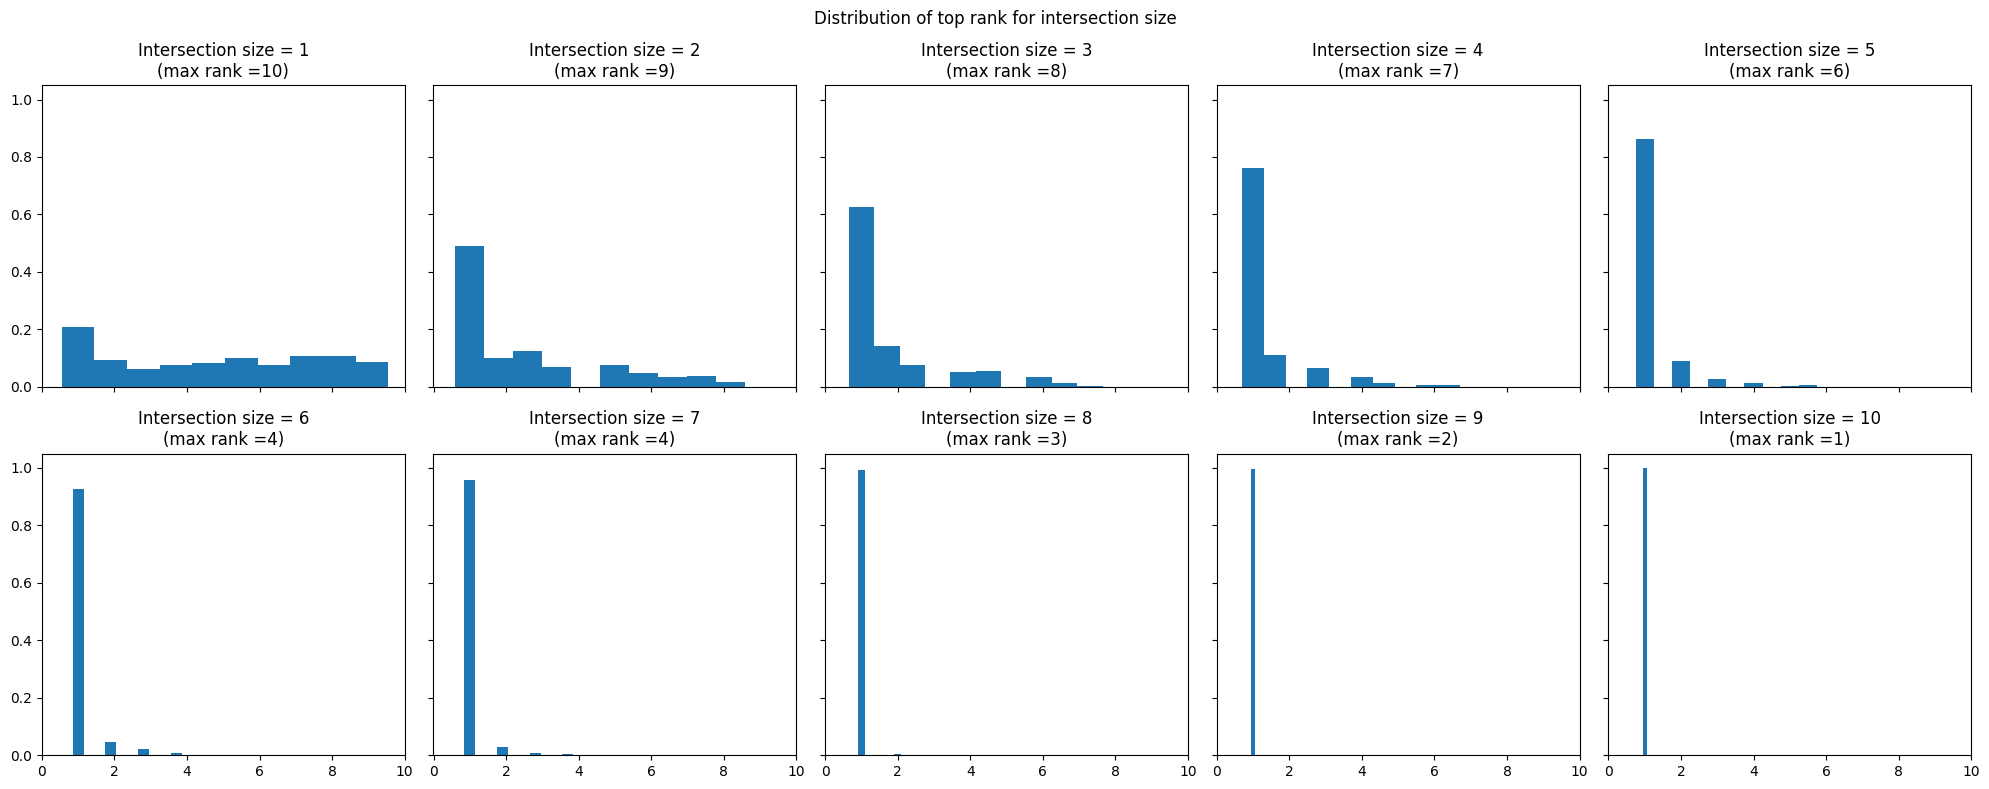

In [46]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axx = ax.flatten()
for pos in range(1, 11):
    ranks = df_inter_ds[(df_inter_ds["inter_size"] == pos)&(df_inter_ds["top_rank"] < 999)].top_rank
    hist, bins = np.histogram(ranks, bins=10)
    
    # ranks.hist(label=str(pos), ax=axx[pos-1], bins=10)
    axx[pos-1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

    axx[pos-1].set_title("Intersection size = " + str(pos) + "\n(max rank =" + str(ranks.max()) + ")")

plt.suptitle("Distribution of top rank for intersection size")
plt.tight_layout()
# plt.savefig("img/automatic_metric/top_rank_threshold.png", dpi=300, bbox_inches="tight")

In [47]:
threshold = 10

df_inter_cc.loc[:, "tp"] = df_inter_cc.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)
df_inter_ds.loc[:, "tp"] = df_inter_ds.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)

# df_inter_cc[df_inter_cc["filenameid"] == "30180978_3"]

df_inter_cc[df_inter_cc["tp"] == 1]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10,1,1
27,DISEASE,monophasic ventricular tachycardia,25350173,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3715,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,10,1,1
54,DISEASE,VT,25350173,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3716,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,10,1,1
242,MEDICATION,amiodarone,25350173,"[372821002, 69236009, 69236009, 52574003, 9629...","[Amiodarone, Product containing amiodarone, Am...",10899,MEDICATION,amiodarone,"[372821002, 69236009, 69236009, 52574003, 9629...","[Amiodarone, Product containing amiodarone, Am...",11016,10,1,1
269,MEDICATION,adenosine,25350173,"[35431001, 108502004, 108502004, 30065008, 702...","[Adenosine, Product containing adenosine, Aden...",10900,MEDICATION,adenosine,"[35431001, 108502004, 108502004, 30065008, 702...","[Adenosine, Product containing adenosine, Aden...",11017,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143588,PROCEDURE,Right heart catheterization,39101327,"[40403005, 40403005, 40403005, 40403005, 40403...","[Right heart catheterization, Cardiac catheter...",21265,PROCEDURE,Right heart catheterization,"[40403005, 40403005, 40403005, 40403005, 40403...","[Right heart catheterization, Cardiac catheter...",20734,10,1,1
1143663,PROCEDURE,PCR,39101327,"[702675006, 9718006, 258066000, 258066000, 258...","[PCR, PCR analysis, Polymerase chain reaction,...",21267,PROCEDURE,PCR,"[702675006, 9718006, 258066000, 258066000, 258...","[PCR, PCR analysis, Polymerase chain reaction,...",20735,10,1,1
1143701,PROCEDURE,blood culture,39101327,"[30088009, 121238005, 104178000, 878860002, 10...","[Blood culture, Fungal blood culture, Bacteria...",21268,PROCEDURE,blood culture,"[30088009, 121238005, 104178000, 878860002, 10...","[Blood culture, Fungal blood culture, Bacteria...",20736,10,1,1
1143777,PROCEDURE,Heart valve intervention,39101327,"[119767007, 112815000, 307799000, 73544002, 11...","[Heart valve injection, Implantation of heart ...",21270,PROCEDURE,Heart valve intervention,"[119767007, 112815000, 307799000, 73544002, 11...","[Heart valve injection, Implantation of heart ...",20738,10,1,1


In [48]:
example = df_inter_cc[(df_inter_cc["inter_size"] == 5)&(df_inter_cc["top_rank"] == 3)].iloc[1]
example

label_cc                                                 PROCEDURE
text_cc                        3D-transesophageal echocardiography
filenameid                                                29558902
codes_cc         [445864005, 445864005, 105376000, 445864005, 1...
terms_cc         [Three dimensional transesophageal echocardiog...
mention_id_cc                                                19522
label_ds                                                 PROCEDURE
text_ds                             Transthoracic Echocardiography
codes_ds         [433236007, 105376000, 105376000, 105376000, 7...
terms_ds         [Transthoracic echocardiography, Transesophage...
mention_id_ds                                                19138
inter_size                                                       5
top_rank                                                         3
tp                                                               0
Name: 78539, dtype: object

In [49]:
list(set(example["terms_cc"]).intersection(set(example["terms_ds"])))

['Transesophageal echocardiography',
 'TOE - Transesophageal echocardiography',
 'Transesophageal echocardiogram',
 'Transoesophageal echocardiography',
 'Doppler transesophageal echocardiography']

In [50]:
threshold = 6

df_inter_cc.loc[:, "tp"] = df_inter_cc.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)
df_inter_ds.loc[:, "tp"] = df_inter_ds.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)

# df_inter_cc[df_inter_cc["filenameid"] == "30180978_3"]

df_inter_cc[df_inter_cc["tp"] == 1]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
0,DISEASE,smoker,25350173,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3714,DISEASE,smoker,"[77176002, 65568007, 230065006, 77176002, 7717...","[Smoker, Cigarette smoker, Chain smoker, Smoki...",3795,10,1,1
27,DISEASE,monophasic ventricular tachycardia,25350173,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3715,DISEASE,monophasic ventricular tachycardia,"[251158004, 25569003, 1237128001, 25569003, 11...","[Ventricular tachycardia, monomorphic, Ventric...",3796,10,1,1
54,DISEASE,VT,25350173,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3716,DISEASE,VT,"[25569003, 25569003, 111852003, 82515000, 2339...","[VT - ventricular tachycardia, Ventricular tac...",3797,10,1,1
107,DISEASE,LV) with a large aneurysm,25350173,"[297160003, 297160003, 297160003, 253544001, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3718,DISEASE,Severely dilated left ventricle (LV) with a la...,"[297160003, 297160003, 297160003, 297160003, 2...","[Left ventricular aneurysm, LVA - Left ventric...",3798,7,1,1
215,DISEASE,the arrhythmogenic scar tissue,25350173,"[880040003, 735686002, 75403004, 253528005, 69...",[Arrhythmogenic left ventricular cardiomyopath...,3722,DISEASE,arrhythmogenic scar tissue,"[880040003, 735686002, 698247007, 253528005, 7...",[Arrhythmogenic left ventricular cardiomyopath...,3802,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143929,SYMPTOM,severely reduced right heart function,39101327,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",31218,SYMPTOM,severely reduced right heart function,"[39589002, 367363000, 367363000, 473365008, 47...","[Hypoplasia of right heart, Right heart failur...",30156,10,1,1
1143967,SYMPTOM,left ventricular chamber size was enlarged,39101327,"[373128001, 93053007, 373126002, 93051009, 253...","[Markedly enlarged cardiac chamber, Congenital...",31219,SYMPTOM,enlarged left ventricular chamber,"[93053007, 373128001, 93051009, 373126002, 253...","[Congenital enlarged ventricular chamber, Mark...",30157,7,1,1
1144080,SYMPTOM,) in,39101327,"[161056001, 315444002, 2438005, 77599005, 7759...","[In care, Born in India, Iniencephaly, Toeing-...",31222,SYMPTOM,in,"[161056001, 2438005, 127569003, 315444002, 775...","[In care, Iniencephaly, In situ neoplasm, Born...",30159,6,1,1
1144118,SYMPTOM,were negative,39101327,"[278154007, 442225006, 168386007, 309306009, 1...","[Group AB neg, Negative measurement finding, C...",31223,SYMPTOM,: Negative,"[442225006, 278154007, 225462008, 165746003, 3...","[Negative measurement finding, Group AB neg, N...",30160,6,1,1


In [52]:

d_dfs = {}
for threshold in range(1, 11):
    df_inter_cc.loc[:, "tp"] = df_inter_cc.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)
    df_inter_ds.loc[:, "tp"] = df_inter_ds.apply(lambda x: int(x["inter_size"] >= threshold), axis=1)

    # df_inter_cc[df_inter_cc["filenameid"] == "30180978_3"]

    df_inter_cc[df_inter_cc["tp"] == 1]

    df_auto_score_cc = df_inter_cc.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_cc = df_auto_score_cc.merge(df_n_mentions_cc, on="filenameid", how="left")
    # df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
    df_auto_score_cc = df_auto_score_cc.fillna(0)

    df_auto_score_ds = df_inter_ds.groupby("filenameid")["tp"].sum().reset_index()
    df_auto_score_ds = df_auto_score_ds.merge(df_n_mentions_ds, on="filenameid", how="left")
    # df_auto_score_ds = df_auto_score_ds.rename(columns={"tp": "tp_ds"})
    df_auto_score_ds = df_auto_score_ds.fillna(0)

    print(df_auto_score_cc.shape, df_auto_score_ds.shape)

    df_auto_score = df_auto_score_cc.merge(df_auto_score_ds, on="filenameid", how="left", suffixes=("_cc", "_ds"))
    df_auto_score["precision"] = df_auto_score["tp_ds"] / df_auto_score["n_mentions_ds"]
    df_auto_score["recall"] = df_auto_score["tp_cc"] / df_auto_score["n_mentions_cc"]
    df_auto_score["f1"] = 2 * df_auto_score["precision"] * df_auto_score["recall"] / (df_auto_score["precision"] + df_auto_score["recall"])
    df_auto_score = df_auto_score.sort_values(by="f1", ascending=False).reset_index(drop=True).fillna(0)
    df_auto_score.to_csv(f"nbs/evaluation/automatic/auto_eval_thres/NOIOB_EN_auto_score_thres_{threshold}.tsv", sep="\t", index=False)
    
    d_dfs[threshold] = [df_auto_score, df_inter_cc, df_inter_ds]

(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)
(1000, 3) (1000, 3)


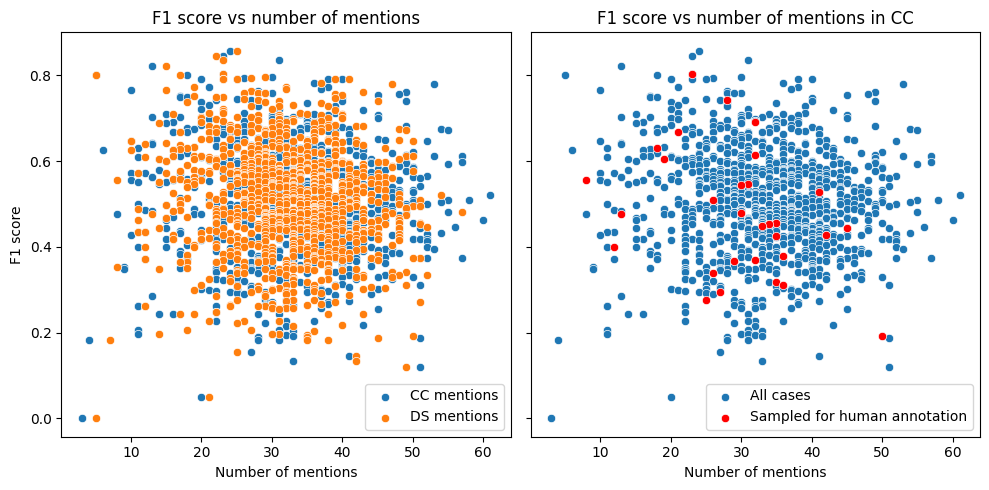

In [158]:
import seaborn as sns

ls_human_files = pd.read_csv("output/samples/en/phase_3/human_eval.tsv", sep="\t")["doc_id"].tolist()
df_auto_human = df_auto_score_final[df_auto_score_final["filenameid"].isin(ls_human_files)]

df_auto_score_final, df_inter_cc_final, df_inter_ds_final = d_dfs[10]
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(df_auto_score_final,  x="n_mentions_cc", y="f1", label="CC mentions", ax=ax[0])
sns.scatterplot(df_auto_score_final,  x="n_mentions_ds", y="f1", label="DS mentions", ax=ax[0])
ax[0].set_title("F1 score vs number of mentions")
ax[0].set_xlabel("Number of mentions")
ax[0].set_ylabel("F1 score")

sns.scatterplot(df_auto_score_final,  x="n_mentions_cc", y="f1", label="All cases", ax=ax[1])
sns.scatterplot(df_auto_human,  x="n_mentions_ds", y="f1", label="Sampled for human annotation", ax=ax[1], color="red")
ax[1].set_title("F1 score vs number of mentions in CC")
ax[1].set_xlabel("Number of mentions")
ax[1].set_ylabel("F1 score")
plt.tight_layout()
plt.savefig("img/results_analysis/f1_vs_mentions.png", dpi=300, bbox_inches="tight")
# sns.scatterplot(df_auto_score_final,  x="n_mentions_ds", y="f1")


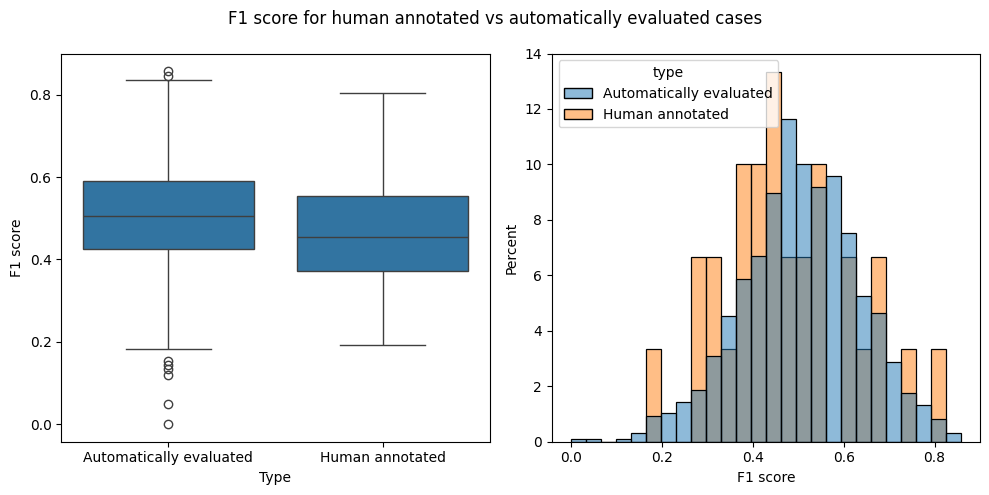

In [175]:
# Compare the boxplots of F1 score for human annotated vs automatically evaluated cases
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_auto_score_final["type"] = "Automatically evaluated"
df_auto_score_final.loc[df_auto_score_final["filenameid"].isin(ls_human_files), "type"] = "Human annotated"
sns.boxplot(data=df_auto_score_final, x="type", y="f1", ax=ax[0])
ax[0].set_xlabel("Type")
ax[0].set_ylabel("F1 score")

# Plot the density of F1 score for human annotated vs automatically evaluated cases
sns.histplot(data=df_auto_score_final, x="f1", hue="type", ax=ax[1], stat="percent", common_norm=False)
ax[1].set_xlabel("F1 score")
plt.suptitle("F1 score for human annotated vs automatically evaluated cases")
plt.tight_layout()

plt.savefig("img/results_analysis/f1_vs_mentions_human_vs_auto.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'F1 score')

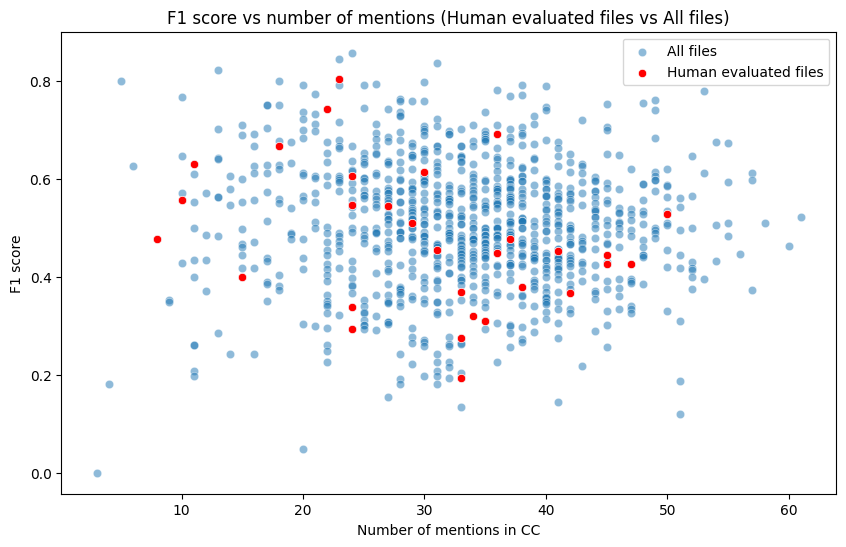

In [134]:
ls_human_files = pd.read_csv("output/samples/en/phase_3/human_eval.tsv", sep="\t")["doc_id"].tolist()
df_auto_human = df_auto_score_final[df_auto_score_final["filenameid"].isin(ls_human_files)]

# Plotting the F1 score for human evaluated files vs all
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_auto_score_final, x="n_mentions_cc", y="f1", label="All files", alpha=0.5)
sns.scatterplot(data=df_auto_human, x="n_mentions_cc", y="f1", label="Human evaluated files", color='red')
plt.title("F1 score vs number of mentions (Human evaluated files vs All files)")
plt.xlabel("Number of mentions in CC")
plt.ylabel("F1 score")

In [135]:

df_n_mentions_cc_label = df_inter_cc.groupby(["filenameid", "label_cc"])["mention_id_cc"].nunique().reset_index().rename(columns={"label_cc": "label",
                                                                                                                                  "mention_id_cc": "n_mentions_cc"})
df_n_mentions_ds_label = df_inter_ds.groupby(["filenameid", "label_ds"])["mention_id_ds"].nunique().reset_index().rename(columns={"label_ds": "label",
                                                                                                                                    "mention_id_ds": "n_mentions_ds"})

df_auto_score_cc_label = df_inter_cc.groupby(["filenameid", "label_cc"])["tp"].sum().reset_index().rename(columns={"label_cc": "label"})
df_auto_score_cc_label = df_auto_score_cc_label.merge(df_n_mentions_cc_label, on=["filenameid", "label"], how="left")
# df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
df_auto_score_cc_label = df_auto_score_cc_label.fillna(0)

df_auto_score_ds_label = df_inter_ds.groupby(["filenameid", "label_ds"])["tp"].sum().reset_index().rename(columns={"label_ds": "label"})
df_auto_score_ds_label = df_auto_score_ds_label.merge(df_n_mentions_ds_label, on=["filenameid", "label"], how="left")
# df_auto_score_cc = df_auto_score_cc.rename(columns={"tp": "tp_cc"})
df_auto_score_ds_label = df_auto_score_ds_label.fillna(0)

print(df_auto_score_cc_label.shape, df_auto_score_ds_label.shape)

df_auto_score_label = df_auto_score_cc_label.merge(df_auto_score_ds_label, on=["filenameid", "label"], how="left", suffixes=("_cc", "_ds"))
df_auto_score_label["precision"] = df_auto_score_label["tp_ds"] / df_auto_score_label["n_mentions_ds"]
df_auto_score_label["recall"] = df_auto_score_label["tp_cc"] / df_auto_score_label["n_mentions_cc"]
df_auto_score_label["f1"] = 2 * df_auto_score_label["precision"] * df_auto_score_label["recall"] / (df_auto_score_label["precision"] + df_auto_score_label["recall"])
df_auto_score_label = df_auto_score_label.sort_values(by="f1", ascending=False).reset_index(drop=True).fillna(0)

df_auto_score_label.sort_values(by=["filenameid", "label"], inplace=True)
df_auto_score_label 

(3487, 4) (3487, 4)


,filenameid,label,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
2672,25350173,DISEASE,3,9,3,8,0.375000,0.333333,0.352941
303,25350173,MEDICATION,2,2,2,2,1.000000,1.000000,1.000000
1407,25350173,PROCEDURE,8,15,8,13,0.615385,0.533333,0.571429
2784,25350173,SYMPTOM,1,3,1,3,0.333333,0.333333,0.333333
799,25531204,DISEASE,7,11,7,9,0.777778,0.636364,0.700000
...,...,...,...,...,...,...,...,...,...
647,39098903,SYMPTOM,3,4,3,4,0.750000,0.750000,0.750000
734,39101327,DISEASE,9,12,9,13,0.692308,0.750000,0.720000
467,39101327,MEDICATION,7,9,7,8,0.875000,0.777778,0.823529
1027,39101327,PROCEDURE,6,10,6,8,0.750000,0.600000,0.666667


In [176]:
df_auto_score_label.groupby("label")[["precision", "recall", "f1"]].mean().sort_values(by="f1", ascending=False)

,precision,recall,f1
label,,,
MEDICATION,0.811873,0.793656,0.780365
DISEASE,0.566541,0.552253,0.548314
PROCEDURE,0.467693,0.457081,0.451334
SYMPTOM,0.474927,0.449442,0.448165


In [178]:
df_auto_score_final.describe()

,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,16.236000,33.160000,16.507000,32.122000,0.518461,0.497329,0.503769
std,5.808101,9.691456,5.800482,8.439451,0.140762,0.135136,0.129968
min,0.000000,3.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,12.000000,27.000000,13.000000,27.000000,0.434420,0.405405,0.423529
50%,16.000000,33.000000,16.000000,32.000000,0.518519,0.489996,0.501133
75%,20.000000,40.000000,20.000000,38.000000,0.613524,0.580645,0.590350
max,39.000000,61.000000,39.000000,57.000000,0.956522,0.900000,0.857143


In [181]:
df_auto_human.describe()

,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,13.566667,30.166667,13.833333,29.466667,0.487318,0.474768,0.476090
std,5.223840,11.045621,5.113089,9.522146,0.148014,0.158368,0.145128
min,5.000000,8.000000,5.000000,8.000000,0.160000,0.242424,0.192771
25%,9.500000,24.000000,10.250000,25.250000,0.385684,0.364833,0.371518
50%,14.000000,32.000000,14.000000,30.500000,0.485281,0.438438,0.453939
75%,17.000000,36.750000,17.000000,35.000000,0.577913,0.607639,0.553030
max,24.000000,50.000000,24.000000,50.000000,0.826087,0.818182,0.803760


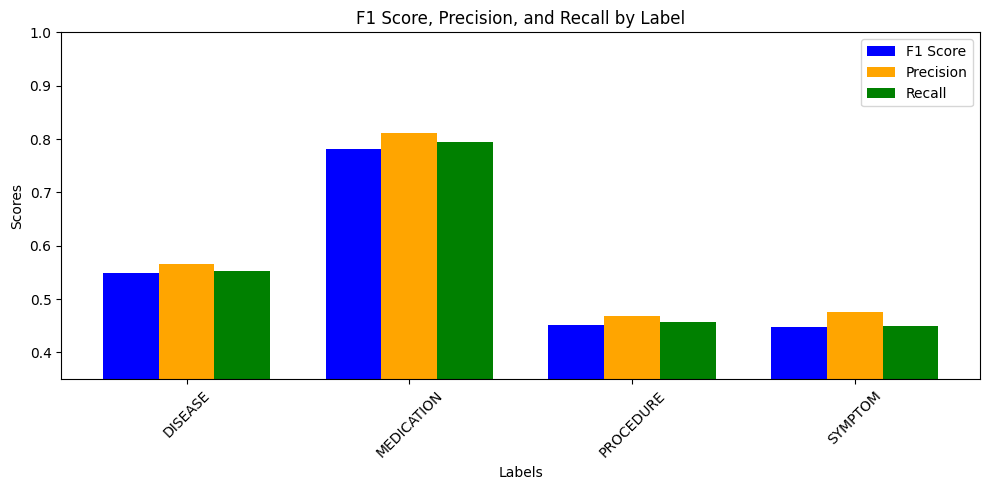

In [146]:
# Plot F1 score, precision, and recall for each label in a bar chart with three bars per label
import matplotlib.pyplot as plt
labels = df_auto_score_label["label"].unique()
x = range(len(labels))
width = 0.25  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, df_auto_score_label.groupby("label")["f1"].mean(), width=width, label='F1 Score', color='blue')
ax.bar([i + width for i in x], df_auto_score_label.groupby("label")["precision"].mean(), width=width, label='Precision', color='orange')
ax.bar([i + 2 * width for i in x], df_auto_score_label.groupby("label")["recall"].mean(), width=width, label='Recall', color='green')
ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('F1 Score, Precision, and Recall by Label')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.set_ylim(0.35, 1)
plt.tight_layout()
plt.savefig("img/results_analysis/f1_precision_recall_by_label.png", dpi=300, bbox_inches="tight")

In [58]:
print(df_auto_score_label[df_auto_score_label["precision"] > 1])
print(df_auto_score_label[df_auto_score_label["recall"] > 1])
print(df_auto_score_label[df_auto_score_label["f1"] > 1])

Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []
Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []
Empty DataFrame
Columns: [filenameid, label, tp_cc, n_mentions_cc, tp_ds, n_mentions_ds, precision, recall, f1]
Index: []


In [59]:
bottom_5 = df_auto_score.sort_values(by="f1", ascending=True).head(5).filenameid.tolist()
top_5 = df_auto_score.sort_values(by="f1", ascending=False).head(5).filenameid.tolist()

In [60]:
df_auto_score.sort_values(by="f1", ascending=False).head(5)

,filenameid,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
0,33385524_2,21,24,21,25,0.840000,0.875000,0.857143
1,31256507_1,19,23,19,22,0.863636,0.826087,0.844444
2,35502126,23,31,22,23,0.956522,0.741935,0.835673
3,31277119,11,13,12,15,0.800000,0.846154,0.822430
4,34946264,18,23,19,23,0.826087,0.782609,0.803760


In [61]:
df_auto_score.sort_values(by="f1", ascending=True).head(5)

,filenameid,tp_cc,n_mentions_cc,tp_ds,n_mentions_ds,precision,recall,f1
999,30180978_3,0,3,0,5,0.000000,0.000000,0.000000
998,34310587,1,20,1,21,0.047619,0.050000,0.048780
997,31974261,6,51,6,49,0.122449,0.117647,0.120000
996,35456383,5,33,5,42,0.119048,0.151515,0.133333
995,38541118,6,41,6,42,0.142857,0.146341,0.144578


In [63]:
df_inter_cc[df_inter_cc["filenameid"].isin([top_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
554332,DISEASE,ischemic cardiomyopathy,33385524_2,"[194849004, 194849004, 426856002, 426856002, 2...","[Ischemic cardiomyopathy, Ischaemic cardiomyop...",7663,DISEASE,Ischemic cardiomyopathy,"[194849004, 194849004, 426856002, 426856002, 2...","[Ischemic cardiomyopathy, Ischaemic cardiomyop...",7795,10,1,1
554358,DISEASE,atrial fibrillation/flutter,33385524_2,"[49436004, 49436004, 5370000, 715395008, 19508...","[AF - Atrial fibrillation, Atrial fibrillation...",7664,DISEASE,atrial fibrillation/flutter,"[49436004, 49436004, 5370000, 715395008, 19508...","[AF - Atrial fibrillation, Atrial fibrillation...",7796,10,1,1
554384,DISEASE,hypertension,33385524_2,"[38341003, 38341003, 38341003, 59621000, 38341...","[Hypertension, HTN - Hypertension, HT - Hypert...",7665,DISEASE,hypertension,"[38341003, 38341003, 38341003, 59621000, 38341...","[Hypertension, HTN - Hypertension, HT - Hypert...",7797,10,1,1
554410,DISEASE,hyperlipidemia,33385524_2,"[55822004, 129590000, 129589009, 13644009, 558...","[Hyperlipidemia, Exogenous hyperlipidemia, End...",7666,DISEASE,hyperlipidemia,"[55822004, 129590000, 129589009, 13644009, 558...","[Hyperlipidemia, Exogenous hyperlipidemia, End...",7798,10,1,1
554436,DISEASE,chronic kidney disease,33385524_2,"[709044004, 709044004, 709044004, 709044004, 9...","[Chronic kidney disease, CKD - chronic kidney ...",7667,DISEASE,chronic kidney disease,"[709044004, 709044004, 709044004, 709044004, 9...","[Chronic kidney disease, CKD - chronic kidney ...",7799,10,1,1
554462,DISEASE,type 2 diabetes,33385524_2,"[44054006, 44054006, 44054006, 44054006, 44054...","[Type 2 diabetes mellitus, Diabetes mellitus t...",7668,DISEASE,type 2 diabetes,"[44054006, 44054006, 44054006, 44054006, 44054...","[Type 2 diabetes mellitus, Diabetes mellitus t...",7800,10,1,1
554481,DISEASE,pneumonia secondary to SARS-CoV-2 infection,33385524_2,"[882784691000119100, 882784691000119100, 87058...","[Pneumonia caused by SARS-CoV-2, Pneumonia cau...",7669,DISEASE,Pneumonia secondary to SARS-CoV-2 infection,"[882784691000119100, 882784691000119100, 87058...","[Pneumonia caused by SARS-CoV-2, Pneumonia cau...",7794,10,1,1
554514,DISEASE,decompensated heart failure,33385524_2,"[195111005, 424404003, 84114007, 84114007, 423...","[Decompensated cardiac failure, Decompensated ...",7670,DISEASE,decompensated heart failure,"[195111005, 424404003, 84114007, 84114007, 423...","[Decompensated cardiac failure, Decompensated ...",7802,10,1,1
554540,MEDICATION,ceftriaxone,33385524_2,"[372670001, 19841008, 33440000, 19841008, 3870...","[Ceftriaxone, Product containing ceftriaxone, ...",11724,MEDICATION,ceftriaxone,"[372670001, 19841008, 33440000, 19841008, 3870...","[Ceftriaxone, Product containing ceftriaxone, ...",11765,10,1,1
554567,PROCEDURE,implanted with a Boston Scientific RESONATE im...,33385524_2,"[1236755008, 395218007, 233170003, 232968001, ...",[Implantation of biventricular implantable car...,21023,PROCEDURE,Boston Scientific RESONATE implantable cardiac...,"[468542000, 1332390002, 465460004, 467017000, ...","[Dual-chamber implantable defibrillator, Impla...",20514,2,1,0


In [64]:
df_inter_ds[df_inter_ds["filenameid"].isin([top_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
554481,DISEASE,pneumonia secondary to SARS-CoV-2 infection,33385524_2,"[882784691000119100, 882784691000119100, 87058...","[Pneumonia caused by SARS-CoV-2, Pneumonia cau...",7669,DISEASE,Pneumonia secondary to SARS-CoV-2 infection,"[882784691000119100, 882784691000119100, 87058...","[Pneumonia caused by SARS-CoV-2, Pneumonia cau...",7794,10,1,1
554332,DISEASE,ischemic cardiomyopathy,33385524_2,"[194849004, 194849004, 426856002, 426856002, 2...","[Ischemic cardiomyopathy, Ischaemic cardiomyop...",7663,DISEASE,Ischemic cardiomyopathy,"[194849004, 194849004, 426856002, 426856002, 2...","[Ischemic cardiomyopathy, Ischaemic cardiomyop...",7795,10,1,1
554358,DISEASE,atrial fibrillation/flutter,33385524_2,"[49436004, 49436004, 5370000, 715395008, 19508...","[AF - Atrial fibrillation, Atrial fibrillation...",7664,DISEASE,atrial fibrillation/flutter,"[49436004, 49436004, 5370000, 715395008, 19508...","[AF - Atrial fibrillation, Atrial fibrillation...",7796,10,1,1
554384,DISEASE,hypertension,33385524_2,"[38341003, 38341003, 38341003, 59621000, 38341...","[Hypertension, HTN - Hypertension, HT - Hypert...",7665,DISEASE,hypertension,"[38341003, 38341003, 38341003, 59621000, 38341...","[Hypertension, HTN - Hypertension, HT - Hypert...",7797,10,1,1
554410,DISEASE,hyperlipidemia,33385524_2,"[55822004, 129590000, 129589009, 13644009, 558...","[Hyperlipidemia, Exogenous hyperlipidemia, End...",7666,DISEASE,hyperlipidemia,"[55822004, 129590000, 129589009, 13644009, 558...","[Hyperlipidemia, Exogenous hyperlipidemia, End...",7798,10,1,1
554436,DISEASE,chronic kidney disease,33385524_2,"[709044004, 709044004, 709044004, 709044004, 9...","[Chronic kidney disease, CKD - chronic kidney ...",7667,DISEASE,chronic kidney disease,"[709044004, 709044004, 709044004, 709044004, 9...","[Chronic kidney disease, CKD - chronic kidney ...",7799,10,1,1
554462,DISEASE,type 2 diabetes,33385524_2,"[44054006, 44054006, 44054006, 44054006, 44054...","[Type 2 diabetes mellitus, Diabetes mellitus t...",7668,DISEASE,type 2 diabetes,"[44054006, 44054006, 44054006, 44054006, 44054...","[Type 2 diabetes mellitus, Diabetes mellitus t...",7800,10,1,1
554338,DISEASE,ischemic cardiomyopathy,33385524_2,"[194849004, 194849004, 426856002, 426856002, 2...","[Ischemic cardiomyopathy, Ischaemic cardiomyop...",7663,DISEASE,pneumonia,"[233604007, 53084003, 205237003, 396285007, 42...","[Pneumonia, Bacterial pneumonia, Pneumonitis, ...",7801,0,999,0
554514,DISEASE,decompensated heart failure,33385524_2,"[195111005, 424404003, 84114007, 84114007, 423...","[Decompensated cardiac failure, Decompensated ...",7670,DISEASE,decompensated heart failure,"[195111005, 424404003, 84114007, 84114007, 423...","[Decompensated cardiac failure, Decompensated ...",7802,10,1,1
554540,MEDICATION,ceftriaxone,33385524_2,"[372670001, 19841008, 33440000, 19841008, 3870...","[Ceftriaxone, Product containing ceftriaxone, ...",11724,MEDICATION,ceftriaxone,"[372670001, 19841008, 33440000, 19841008, 3870...","[Ceftriaxone, Product containing ceftriaxone, ...",11765,10,1,1


In [65]:
df_inter_cc[df_inter_cc["filenameid"].isin([bottom_5[1]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
695943,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
695965,DISEASE,anemia,34310587,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3685,DISEASE,anemia,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3761,10,1,1
695985,DISEASE,sÃŃntomas de insuficiencia cardÃŃaca,34310587,"[72266002, 396331005, 396331005, 127117004, 11...","[Nodosity, Coeliac disease, Coeliac syndrome, ...",3686,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696006,DISEASE,miocardiopatÃŃa dilatada,34310587,"[194828000, 424889004, 64077000, 1197364005, 5...","[Stenocardia, Sinistrocardia, Myocardial degen...",3687,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696027,DISEASE,dis,34310587,"[64572001, 64572001, 64572001, 64572001, 40733...","[Disease, Diseases, Disorders, Disorder, Infec...",3688,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696048,DISEASE,dilataci,34310587,"[295055000, 721093000, 294602004, 721093000, 2...","[Digitoxin allergy, Dianzani autoimmune lympho...",3689,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696074,DISEASE,disfunciÃ³n biventricular grave,34310587,"[472776004, 92506005, 472776004, 2851210001191...","[Fetal biventricular dysfunction, Biventricula...",3690,DISEASE,severe biventricular dilation and dysfunction,"[472776004, 472776004, 92506005, 92506005, 621...","[Fetal biventricular dysfunction, Foetal biven...",3765,5,1,0
696099,DISEASE,miocardiopatÃŃa por infiltraciÃ³n de hierro,34310587,"[871646007, 471870000, 785847000, 64749001, 39...","[Infiltrative cardiomyopathy, Pacing-induced c...",3691,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,2,1,0
696120,DISEASE,infiltraciÃ³n moderada de hierro cardÃŃaco,34310587,"[60002000, 60002000, 860889002, 651003, 403670...","[Gastritis hypertrophica gigantea, Gastritis h...",3692,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,1,6,0
696140,DISEASE,fibrosis difusa de,34310587,"[125564007, 13876002, 263756000, 112674009, 31...","[Diffuse fibrosis, Fibrosing dermatitis, Fibro...",3693,DISEASE,diffuse epicardial fibrosis,"[398716006, 125564007, 398754006, 65457005, 68...","[Endomyocardial fibrosis, Diffuse fibrosis, Af...",3768,1,1,0


In [66]:
df_inter_ds[df_inter_ds["filenameid"].isin([bottom_5[0]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
147939,DISEASE,dilative cardiomyopathy,30180978_3,"[399020009, 399020009, 195021004, 165468981000...","[Dilated cardiomyopathy, DCM - Dilated cardiom...",4252,DISEASE,Dilated Cardiomyopathy,"[399020009, 399020009, 399020009, 52029003, 19...","[Dilated cardiomyopathy, DCM - Dilated cardiom...",4321,7,1,0
147945,PROCEDURE,HeartMate 3 explantation,30180978_3,"[232975000, 31019002, 50225007, 284101009, 339...","[Harvest of heart, Implantation of artificial ...",17036,PROCEDURE,explantation of the HeartMate 3 device,"[62881002, 284101009, 3479000, 50225007, 27684...","[Removal of pacemaker device, Removal of impla...",16778,5,1,0
147946,PROCEDURE,HeartMate 3 explantation,30180978_3,"[232975000, 31019002, 50225007, 284101009, 339...","[Harvest of heart, Implantation of artificial ...",17036,PROCEDURE,removal of the HeartMate 3 pump,"[50225007, 3479000, 443262001, 3479000, 628810...","[Removal of heart assist system, Removal of he...",16779,3,1,0
147947,PROCEDURE,HeartMate 3 explantation,30180978_3,"[232975000, 31019002, 50225007, 284101009, 339...","[Harvest of heart, Implantation of artificial ...",17036,PROCEDURE,plug was inserted into the left ventricle,"[232967006, 105373008, 240286000, 414511001, 7...",[Implantation of left cardiac ventricular assi...,16780,0,999,0
147948,PROCEDURE,HeartMate 3 explantation,30180978_3,"[232975000, 31019002, 50225007, 284101009, 339...","[Harvest of heart, Implantation of artificial ...",17036,PROCEDURE,imaging,"[363679005, 363679005, 41747008, 371575001, 36...","[Imaging, Clinical imaging, Bone imaging, Tomo...",16781,0,999,0


In [67]:
df_inter_cc[df_inter_cc["filenameid"].isin([bottom_5[1]])]

,label_cc,text_cc,filenameid,codes_cc,terms_cc,mention_id_cc,label_ds,text_ds,codes_ds,terms_ds,mention_id_ds,inter_size,top_rank,tp
695943,DISEASE,sÃŃndrome mielodisplÃ¡sico,34310587,"[723995003, 723995003, 403839008, 416137008, 2...","[Schimke immuno-osseous dysplasia, Schimke imm...",3684,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
695965,DISEASE,anemia,34310587,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3685,DISEASE,anemia,"[271737000, 271737000, 271737000, 66612000, 27...","[Anemia, Anaemia, Absolute anemia, Nutritional...",3761,10,1,1
695985,DISEASE,sÃŃntomas de insuficiencia cardÃŃaca,34310587,"[72266002, 396331005, 396331005, 127117004, 11...","[Nodosity, Coeliac disease, Coeliac syndrome, ...",3686,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696006,DISEASE,miocardiopatÃŃa dilatada,34310587,"[194828000, 424889004, 64077000, 1197364005, 5...","[Stenocardia, Sinistrocardia, Myocardial degen...",3687,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696027,DISEASE,dis,34310587,"[64572001, 64572001, 64572001, 64572001, 40733...","[Disease, Diseases, Disorders, Disorder, Infec...",3688,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696048,DISEASE,dilataci,34310587,"[295055000, 721093000, 294602004, 721093000, 2...","[Digitoxin allergy, Dianzani autoimmune lympho...",3689,DISEASE,myelodysplastic syndrome,"[128623006, 109995007, 109995007, 109995007, 1...","[Myelodysplastic syndrome, Myelodysplastic syn...",3760,0,999,0
696074,DISEASE,disfunciÃ³n biventricular grave,34310587,"[472776004, 92506005, 472776004, 2851210001191...","[Fetal biventricular dysfunction, Biventricula...",3690,DISEASE,severe biventricular dilation and dysfunction,"[472776004, 472776004, 92506005, 92506005, 621...","[Fetal biventricular dysfunction, Foetal biven...",3765,5,1,0
696099,DISEASE,miocardiopatÃŃa por infiltraciÃ³n de hierro,34310587,"[871646007, 471870000, 785847000, 64749001, 39...","[Infiltrative cardiomyopathy, Pacing-induced c...",3691,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,2,1,0
696120,DISEASE,infiltraciÃ³n moderada de hierro cardÃŃaco,34310587,"[60002000, 60002000, 860889002, 651003, 403670...","[Gastritis hypertrophica gigantea, Gastritis h...",3692,DISEASE,infiltrative iron cardiomyopathy,"[871646007, 64749001, 194849004, 194849004, 42...","[Infiltrative cardiomyopathy, Infiltrative dil...",3769,1,6,0
696140,DISEASE,fibrosis difusa de,34310587,"[125564007, 13876002, 263756000, 112674009, 31...","[Diffuse fibrosis, Fibrosing dermatitis, Fibro...",3693,DISEASE,diffuse epicardial fibrosis,"[398716006, 125564007, 398754006, 65457005, 68...","[Endomyocardial fibrosis, Diffuse fibrosis, Af...",3768,1,1,0
